# Week 8: Scalable Machine Learning with Spark MLlib

**Course:** Big Data Management (Master's Level)

**Author:** Ahmed Soliman

**Objective:** This lab introduces Spark's MLlib library for building and evaluating machine learning models on large datasets. We will focus on constructing ML pipelines, feature engineering, model training, and hyperparameter tuning within the Spark ecosystem.

<style>
h1 {
    color: #0D47A1; /* Dark Blue color for H1 */
    border-bottom: 2px solid #0D47A1;
}
.toc {
    border: 1px solid #ccc;
    padding: 15px;
    margin-bottom: 20px;
    background-color: #f9f9f9;
    border-radius: 5px;
}
.toc h2 {
    margin-top: 0;
    border-bottom: none;
    color: #333;
}
.toc ul {
    list-style-type: none;
    padding-left: 0;
}
.toc li {
    margin-bottom: 5px;
}
.toc li a {
    text-decoration: none;
    color: #1976D2; /* Link color */
}
.toc li a:hover {
    text-decoration: underline;
}
</style>

<div class="toc">
<h2>Table of Contents</h2>
<ul>
<li><a href="#lab-goals">Lab Goals</a></li>
<li><a href="#core-concepts">Core Concepts in SparkML Pipelines</a></li>
<li><a href="#setup">Setup: Initializing Spark Session</a></li>
<li><a href="#task-1">Task 1: Data Loading and Initial Exploration</a>
  <ul>
    <li><a href="#load-data">1.1 Load Data</a></li>
    <li><a href="#clean-columns">1.2 Data Cleaning: Column Names</a></li>
    <li><a href="#infer-schema">1.3 Infer Schema and Inspect Data Types</a></li>
    <li><a href="#explore-data">1.4 Initial Data Exploration</a></li>
    <li><a href="#summary-stats">1.5 Summary Statistics</a></li>
    <li><a href="#categorical-analysis">1.6 Categorical Feature Analysis</a></li>
    <li><a href="#missing-values">1.7 Check for Missing Values</a></li>
    <li><a href="#visualization">1.8 Data Visualization (Optional)</a></li>
  </ul>
</li>
<li><a href="#task-2">Task 2: Feature Engineering and Pipeline Construction</a>
  <ul>
    <li><a href="#feature-engineering-age">2.1 Feature Engineering: Adding `age_square`</a></li>
    <li><a href="#pipeline-stages-def">2.2 Defining Pipeline Stages</a></li>
       <ul>
           <li><a href="#stage-cat">2.2.1 Categorical Feature Processing (Indexing & Encoding)</a></li>
           <li><a href="#stage-label">2.2.2 Label Indexing</a></li>
           <li><a href="#stage-assemble">2.2.3 Feature Assembling</a></li>
       </ul>
    <li><a href="#pipeline-apply">2.3 Apply the Preprocessing Pipeline</a></li>
  </ul>
</li>
<li><a href="#task-3">Task 3: Model Training and Evaluation</a>
  <ul>
    <li><a href="#split-data">3.1 Split Data</a></li>
    <li><a href="#train-initial">3.2 Train Initial Logistic Regression Model</a></li>
    <li><a href="#predict-initial">3.3 Make Predictions with Initial Model</a></li>
    <li><a href="#eval-initial">3.4 Evaluate Initial Model</a></li>
  </ul>
</li>
<li><a href="#task-4">Task 4: Hyperparameter Tuning with Cross-Validation</a>
  <ul>
    <li><a href="#param-grid">4.1 Define Parameter Grid</a></li>
    <li><a href="#cross-validator">4.2 Set up and Run Cross-Validator</a></li>
    <li><a href="#eval-best">4.3 Evaluate the Best Model from CV</a></li>
  </ul>
</li>
<li><a href="#task-5">Task 5: Model Persistence</a></li>
<li><a href="#task-6">Task 6: Hands-on Challenge</a></li>
<li><a href="#conclusion">Lab Conclusion</a></li>
</ul>
</div>

<a id='lab-goals'></a>\n<a id='lab-goals'></a>
## Lab Goals

Upon completion of this lab, you should be able to:

* Gain practical experience with the SparkML DataFrame-based API.
* Understand the core concepts of SparkML Pipelines: `DataFrame`, `Transformer`, `Estimator`, `Pipeline`, and `Parameter`.
* Implement data preprocessing and feature engineering steps within a SparkML pipeline.
* Build, train, and evaluate a Logistic Regression classification model.
* Perform hyperparameter tuning using `ParamGridBuilder` and `CrossValidator`.
* Understand model persistence for saving and loading SparkML models and pipelines.

**Reference:** [Official Spark MLlib Programming Guide](https://spark.apache.org/docs/latest/ml-guide.html)

<a id='core-concepts-in-sparkml-pipelines'></a>\n<a id='core-concepts'></a>
## Core Concepts in SparkML Pipelines

Spark MLlib provides a unified set of high-level APIs built on top of DataFrames that helps users create and tune practical machine learning pipelines. Key concepts include:

* **`DataFrame`**: The primary data structure used in SparkML. It's equivalent to a table in a relational database or a data frame in R/Python, but distributed across a cluster. DataFrames can hold various data types (text, features, labels, predictions).

* **`Transformer`**: An algorithm that transforms one `DataFrame` into another. Examples include feature transformers (like `StringIndexer`, `OneHotEncoder`, `VectorAssembler`) which modify columns, and trained models which add prediction columns.

* **`Estimator`**: An algorithm that learns from data (a `DataFrame`) to produce a `Transformer`. It implements a `fit()` method. For example, `LogisticRegression` is an `Estimator` that, when `fit()`, produces a `LogisticRegressionModel`, which is a `Transformer`.

* **`Pipeline`**: Chains multiple `Transformer`s and `Estimator`s together into a single workflow. This helps manage the sequence of data processing and modeling steps.

* **`Parameter`**: `Transformer`s and `Estimator`s share a common API for specifying parameters (e.g., `regParam` for regularization in `LogisticRegression`). This allows for standardized configuration and tuning.

<a id='setup-initializing-spark-session'></a>\n<a id='setup'></a>
## Setup: Initializing Spark Session

First, we need to initialize a `SparkSession`, which is the entry point for programming Spark with the DataFrame API.

In [30]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F # Import functions with an alias for clarity
import warnings

# Suppress specific warnings if needed (optional)
# warnings.filterwarnings("ignore", category=FutureWarning, module="pyspark.sql.pandas.conversion")

# Create or get a SparkSession
spark = SparkSession.builder \
    .appName("SparkML Lab - Enhanced") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "1g") \
    .getOrCreate()

# Enable Arrow-based columnar data transfers (improves Spark -> Pandas conversion performance)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# Optional: Enable eager evaluation for better interactive display in notebooks
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

sqlContext = spark # Use spark variable directly, sqlContext is legacy

print(f"Spark Session Initialized. Spark version: {spark.version}")

Spark Session Initialized. Spark version: 3.5.3


<a id='task-1-data-loading-and-initial-exploration'></a>\n<a id='task-1'></a>
## Task 1: Data Loading and Initial Exploration

We will use the 'Adult' dataset from the UCI Machine Learning Repository. This dataset contains census information and is commonly used for predicting whether an individual's income exceeds $50K/year.

**Dataset:** [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/Adult)

<a id='11-load-data'></a>\n<a id='load-data'></a>
### 1.1 Load Data

Load the data from the provided CSV file. We'll initially let Spark load everything as strings and then infer the schema.

In [31]:
# Define the path to the data
# Make sure the 'lab_data/adult.data' file is accessible in your Spark environment
data_path = "./lab_data/adult.data"

# Load data initially as strings to inspect headers
df_string = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .option("ignoreLeadingWhiteSpace", "true") \
    .option("ignoreTrailingWhiteSpace", "true") \
    .load(data_path)

# Inspect column names - they might have leading/trailing spaces or hyphens
print("Original Column Names:")
print(df_string.columns)

Original Column Names:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'maritial-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'category']


<a id='12-data-cleaning-column-names'></a>\n<a id='clean-columns'></a>
### 1.2 Data Cleaning: Column Names

The column names might contain characters like spaces or hyphens that are inconvenient for Spark SQL operations. Let's clean them up.

In [32]:
# Clean column names: remove spaces, replace hyphens with underscores
clean_columns = [col.strip().replace('-', '_') for col in df_string.columns]

# Apply new column names
df_renamed = df_string.toDF(*clean_columns)

print("Cleaned Column Names:")
print(df_renamed.columns)

Cleaned Column Names:
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'maritial_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'category']


<a id='13-infer-schema-and-inspect-data-types'></a>\n<a id='infer-schema'></a>
### 1.3 Infer Schema and Inspect Data Types

Now, load the data again, this time inferring the schema and using the cleaned column names.

In [33]:
# Define schema based on cleaned names for explicit loading (alternative to inferSchema)
# This provides more control and avoids an extra Spark job for inference.
# Based on adult.names file and observation:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", IntegerType(), True), # Final weight
    StructField("education", StringType(), True),
    StructField("education_num", IntegerType(), True),
    StructField("marital_status", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital_gain", IntegerType(), True),
    StructField("capital_loss", IntegerType(), True),
    StructField("hours_per_week", IntegerType(), True),
    StructField("native_country", StringType(), True),
    StructField("category", StringType(), True) # Target variable: <=50K or >50K
])

# Load data with the explicit schema and cleaned names
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("ignoreLeadingWhiteSpace", "true") \
    .option("ignoreTrailingWhiteSpace", "true") \
    .schema(schema) \
    .load(data_path)

# Rename columns after loading (if header=false used)
# df = df.toDF(*clean_columns) # This is redundant if schema is used with correct names

# Print the schema to verify data types
print("DataFrame Schema:")
df.printSchema()

# Cache the DataFrame for faster access in subsequent operations
df.cache()

print(f"\nNumber of records: {df.count()}")

DataFrame Schema:
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- category: string (nullable = true)


Number of records: 32561


<a id='14-initial-data-exploration'></a>\n<a id='explore-data'></a>
### 1.4 Initial Data Exploration

Let's explore the data with some basic operations.

In [34]:
# Display the first few rows (using display for better notebook integration if available, else show)
print("First 5 rows (vertical view):")
try:
    display(df.limit(5))
except NameError:
    df.show(n=5, truncate=False, vertical=True)

# Display using Pandas for comparison (collects data to driver - use limit() for large datasets)
print("\nFirst 5 rows (Pandas view):")
df.limit(5).toPandas()

First 5 rows (vertical view):


DataFrame[age: int, workclass: string, fnlwgt: int, education: string, education_num: int, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: int, capital_loss: int, hours_per_week: int, native_country: string, category: string]


First 5 rows (Pandas view):


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,category
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<a id='15-summary-statistics'></a>\n<a id='summary-stats'></a>
### 1.5 Summary Statistics

Generate descriptive statistics for numerical columns.

In [57]:
# Get summary statistics for all numerical columns
print("Summary Statistics (all numerical columns):")
df.describe().toPandas() # toPandas() for better formatting

Summary Statistics (all numerical columns):


,summary,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,category,age_square
0,count,32561,30725,32561,32561,32561,32561,30718,32561,32561,32561,32561,32561,32561,31978,32561,32561
1,mean,38.58164675532078,None,189778.36651208502,None,10.0806793403151,None,None,None,None,None,1077.6488437087312,87.303829734959,40.437455852092995,None,None,1674.5991523601856
2,stddev,13.640432553581356,None,105549.97769702227,None,2.572720332067397,None,None,None,None,None,7385.292084840354,402.960218649002,12.347428681731838,None,None,1179.0475214363396
3,min,17,Federal-gov,12285,10th,1,Divorced,Adm-clerical,Husband,Amer-Indian-Eskimo,Female,0,0,1,Cambodia,<=50K,289.0
4,max,90,Without-pay,1484705,Some-college,16,Widowed,Transport-moving,Wife,White,Male,99999,4356,99,Yugoslavia,>50K,8100.0


In [58]:
# Summary statistics for a specific column
print("\nSummary Statistics for 'capital_gain':")
df.describe('capital_gain').show()


Summary Statistics for 'capital_gain':
+-------+------------------+
|summary|      capital_gain|
+-------+------------------+
|  count|             32561|
|   mean|1077.6488437087312|
| stddev| 7385.292084840354|
|    min|                 0|
|    max|             99999|
+-------+------------------+



<a id='16-categorical-feature-analysis'></a>\n<a id='categorical-analysis'></a>
### 1.6 Categorical Feature Analysis

Analyze the distribution of categorical features and their relationship with the target variable (`category`).

In [37]:
# Count occurrences of each category (target variable)
print("Target Variable Distribution ('category'):")
df.groupBy("category").count().show()

# Relationship between education and income category (crosstab)
print("\nCrosstab: Education vs Income Category:")
df.crosstab('education', 'category').orderBy("education_category").show()

Target Variable Distribution ('category'):
+--------+-----+
|category|count|
+--------+-----+
|   <=50K|24720|
|    >50K| 7841|
+--------+-----+


Crosstab: Education vs Income Category:
+------------------+-----+----+
|education_category|<=50K|>50K|
+------------------+-----+----+
|              10th|  871|  62|
|              11th| 1115|  60|
|              12th|  400|  33|
|           1st-4th|  162|   6|
|           5th-6th|  317|  16|
|           7th-8th|  606|  40|
|               9th|  487|  27|
|        Assoc-acdm|  802| 265|
|         Assoc-voc| 1021| 361|
|         Bachelors| 3134|2221|
|         Doctorate|  107| 306|
|           HS-grad| 8826|1675|
|           Masters|  764| 959|
|         Preschool|   51|   0|
|       Prof-school|  153| 423|
|      Some-college| 5904|1387|
+------------------+-----+----+



<a id='17-check-for-missing-values'></a>\n<a id='missing-values'></a>
### 1.7 Check for Missing Values

In many real-world datasets, missing values are represented by placeholders like '?'. Let's check if any columns contain such values.

In [59]:
print("Checking for '?' values in string columns:")
string_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
missing_counts = []

for col_name in string_cols:
    # Count occurrences of '?' or potential nulls/empty strings after replace
    count_q = df.filter(F.col(col_name) == '?').count() # Check before replace
    count_null = df.filter(F.col(col_name).isNull()).count() # Check after replace
    total_missing = count_q + count_null
    if total_missing > 0:
        missing_counts.append((col_name, total_missing))

# Replace '?' with null before proceeding
df_no_q = df
for col_name in string_cols:
    df_no_q = df_no_q.withColumn(col_name, F.when(F.col(col_name) == '?', None).otherwise(F.col(col_name)))

df = df_no_q # Update the main dataframe
df.cache() # Recache after transformation

if missing_counts:
    print("Columns containing '?' (now replaced with null):")
    for col, count in missing_counts:
        print(f"  - {col}: {count}")
else:
    print("No '?' values found in string columns.")

# How to handle missing values (now represented as null)? Options:
# 1. Drop rows: df.na.drop()
# 2. Impute: Use SparkML's Imputer transformer
# 3. Let StringIndexer handle them (using handleInvalid='keep' or 'skip')
# For this lab, we'll use handleInvalid='keep' in StringIndexer later.


Checking for '?' values in string columns:
Columns containing '?' (now replaced with null):
  - workclass: 1836
  - occupation: 1843
  - native_country: 583


<a id='18-data-visualization-optional-requires-data-collection'></a>\n<a id='visualization'></a>
### 1.8 Data Visualization (Optional - Requires Data Collection)

Visualizing data distributions can provide valuable insights. **Warning:** This requires collecting data to the Spark driver node. Only do this on reasonably sized samples or aggregated data if working with very large datasets.

Let's visualize the distribution of `age`.

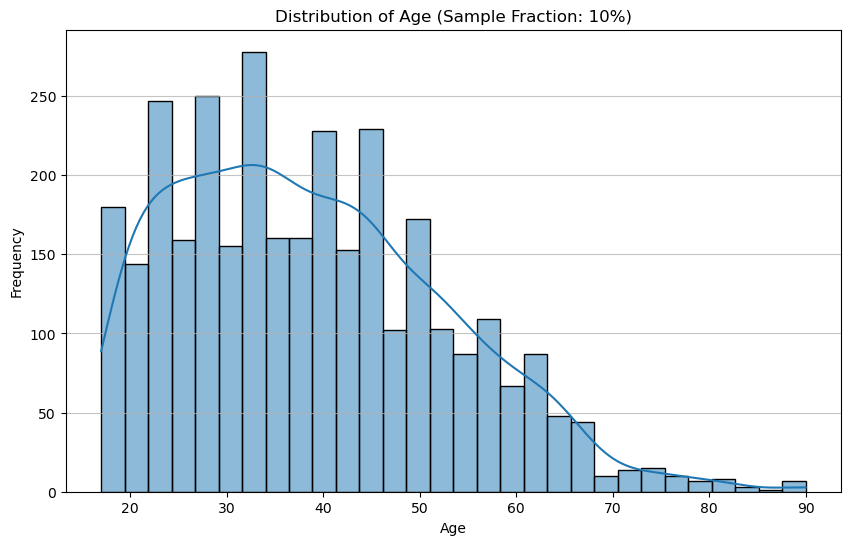

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data for visualization (adjust sample fraction as needed)
sample_fraction = 0.1 # Use 10% of data for the plot
seed = 42

try:
    # Use Arrow for potentially faster conversion
    age_data_pd = df.select('age').sample(withReplacement=False, fraction=sample_fraction, seed=seed).toPandas()

    if not age_data_pd.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(age_data_pd['age'], kde=True, bins=30)
        plt.title(f'Distribution of Age (Sample Fraction: {sample_fraction*100:.0f}%)')
        plt.xlabel('Age')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print(f"Sampling fraction {sample_fraction} resulted in empty data for plotting.")

except Exception as e:
    print(f"Could not generate plot: {e}. Ensure matplotlib, seaborn, and pyarrow are installed.")

<a id='task-2-feature-engineering-and-pipeline-construction'></a>\n<a id='task-2'></a>
## Task 2: Feature Engineering and Pipeline Construction

Machine learning algorithms require numerical input. We need to transform our raw data, especially categorical features, into a format suitable for modeling. SparkML pipelines streamline this process.

<a id='21-feature-engineering-adding-age_square'></a>\n<a id='feature-engineering-age'></a>
### 2.1 Feature Engineering: Adding `age_square`

As relationships might not be linear, adding polynomial features can sometimes improve model performance. Let's add a squared term for age.

In [60]:
# Add age_square feature using withColumn
# Note: Ensure this is idempotent if the notebook cell is run multiple times.
if 'age_square' not in df.columns:
    df = df.withColumn("age_square", F.col("age")**2)
    print("'age_square' column added.")
    df.cache() # Recache after adding column
else:
    print("'age_square' column already exists.")

# Verify by showing schema or first row
df.printSchema()
# df.limit(1).toPandas() # Optional check

'age_square' column already exists.
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- category: string (nullable = true)
 |-- age_square: double (nullable = true)



<a id='22-defining-pipeline-stages'></a>\n<a id='pipeline-stages-def'></a>
### 2.2 Defining Pipeline Stages

We'll build a pipeline consisting of several stages:
1.  **Categorical Feature Processing:** Convert string categories to numerical indices (`StringIndexer`) and then encode these indices into binary sparse vectors (`OneHotEncoder`).
2.  **Label Indexing:** Convert the string target variable (`category`) into numerical labels using `StringIndexer`.
3.  **Feature Assembling:** Combine all processed numerical and encoded categorical features into a single feature vector using `VectorAssembler`.

<a id='221-categorical-feature-processing-indexing-encoding'></a>\n<a id='stage-cat'></a>
#### 2.2.1 Categorical Feature Processing (Indexing & Encoding)

We iterate through the identified categorical columns, creating a `StringIndexer` and a `OneHotEncoder` for each. The `StringIndexer` maps strings to indices, and `OneHotEncoder` maps these indices to sparse binary vectors. We use `handleInvalid='keep'` for the indexer to handle potential missing values (now null) or unseen categories during prediction.

In [61]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Identify categorical columns (excluding target and potentially dropped columns like 'education')
categorical_cols = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

indexers_and_encoders = []
print("Defining stages for categorical features...")
for cat_col in categorical_cols:
    index_col = cat_col + "_Index"
    vec_col = cat_col + "_Vec"

    # Indexer Stage
    string_indexer = StringIndexer(inputCol=cat_col, outputCol=index_col, handleInvalid='keep')
    indexers_and_encoders.append(string_indexer)
    print(f"  Added StringIndexer ({cat_col} -> {index_col})")

    # Encoder Stage
    encoder = OneHotEncoder(inputCols=[index_col], outputCols=[vec_col])
    indexers_and_encoders.append(encoder)
    print(f"  Added OneHotEncoder ({index_col} -> {vec_col})")

# Keep track of the output vector column names for the assembler
categorical_vec_cols = [c + "_Vec" for c in categorical_cols]

Defining stages for categorical features...
  Added StringIndexer (workclass -> workclass_Index)
  Added OneHotEncoder (workclass_Index -> workclass_Vec)
  Added StringIndexer (marital_status -> marital_status_Index)
  Added OneHotEncoder (marital_status_Index -> marital_status_Vec)
  Added StringIndexer (occupation -> occupation_Index)
  Added OneHotEncoder (occupation_Index -> occupation_Vec)
  Added StringIndexer (relationship -> relationship_Index)
  Added OneHotEncoder (relationship_Index -> relationship_Vec)
  Added StringIndexer (race -> race_Index)
  Added OneHotEncoder (race_Index -> race_Vec)
  Added StringIndexer (sex -> sex_Index)
  Added OneHotEncoder (sex_Index -> sex_Vec)
  Added StringIndexer (native_country -> native_country_Index)
  Added OneHotEncoder (native_country_Index -> native_country_Vec)


<a id='222-label-indexing'></a>\n<a id='stage-label'></a>
#### 2.2.2 Label Indexing

Convert the target variable (`category`) from string ('<=50K', '>50K') to numerical labels (0.0, 1.0).

In [62]:
label_col = 'category'
label_output_col = "label" # Standard name for the target label column

label_indexer = StringIndexer(inputCol=label_col, outputCol=label_output_col)
print(f"Added StringIndexer for label ({label_col} -> {label_output_col})")

Added StringIndexer for label (category -> label)


<a id='223-feature-assembling'></a>\n<a id='stage-assemble'></a>
#### 2.2.3 Feature Assembling

Combine all the features (original numerical columns and the newly created one-hot encoded vectors) into a single vector column named `features`. This is the input format required by most SparkML algorithms.

In [63]:
from pyspark.ml.feature import VectorAssembler

# Define numerical columns to include (ensure 'age_square' is present)
numerical_cols = ['age', 'age_square', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

feature_output_col = "features" # Standard name for the features vector
assembler_inputs = categorical_vec_cols + numerical_cols

vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=feature_output_col)
print(f"Added VectorAssembler to create '{feature_output_col}' from {len(assembler_inputs)} columns")

Added VectorAssembler to create 'features' from 14 columns


<a id='23-apply-the-preprocessing-pipeline'></a>\n<a id='pipeline-apply'></a>
### 2.3 Apply the Preprocessing Pipeline

Combine all defined stages into a `Pipeline`, fit it to the entire dataset (`df`) to learn the necessary parameters (like category mappings from `StringIndexer`), and then transform the data.

In [68]:
from pyspark.ml import Pipeline

# Combine all stages: categorical processing, label indexing, feature assembling
all_stages = indexers_and_encoders + [label_indexer, vector_assembler]
preprocessing_pipeline = Pipeline(stages=all_stages)

print(f"Total stages in preprocessing pipeline: {len(all_stages)}")

print("Fitting preprocessing pipeline...")
# Fit the preprocessing pipeline to the data
preprocessing_model = preprocessing_pipeline.fit(df)
print("Pipeline fitting complete.")

print("Transforming data with fitted pipeline...")
# Transform the data
processed_df = preprocessing_model.transform(df)
print("Data transformation complete.")

# Select only the relevant columns for modeling: 'label' and 'features'
model_input_df = processed_df.select(label_output_col, feature_output_col)
model_input_df.cache() # Cache the final data for modeling

print("Schema of data ready for modeling:")
model_input_df.printSchema()

# Show a sample row with the final 'label' and 'features' columns
print("\nSample row for modeling:")


Total stages in preprocessing pipeline: 16
Fitting preprocessing pipeline...
Pipeline fitting complete.
Transforming data with fitted pipeline...
Data transformation complete.
Schema of data ready for modeling:
root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)


Sample row for modeling:


In [67]:
processed_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- category: string (nullable = true)
 |-- age_square: double (nullable = true)
 |-- workclass_Index: double (nullable = false)
 |-- workclass_Vec: vector (nullable = true)
 |-- marital_status_Index: double (nullable = false)
 |-- marital_status_Vec: vector (nullable = true)
 |-- occupation_Index: double (nullable = false)
 |-- occupation_Vec: vector (nullable = true)
 |-- relationship_Index: double (

<a id='task-3-model-training-and-evaluation'></a>\n<a id='task-3'></a>
## Task 3: Model Training and Evaluation

Now that the data is preprocessed and vectorized, we can split it and train our classification model.

<a id='31-split-data'></a>\n<a id='split-data'></a>
### 3.1 Split Data

Split the `model_input_df` into training and testing sets.

In [69]:
# Split data (e.g., 70% training, 30% testing)
split_ratio = [0.7, 0.3]
seed = 123 # Use a fixed seed for reproducibility
train_data, test_data = model_input_df.randomSplit(split_ratio, seed=seed)

# Cache the splits for performance during training and evaluation
train_data.cache()
test_data.cache()

print(f"Training data count: {train_data.count()} ({(train_data.count() / model_input_df.count())*100:.1f}%)")
print(f"Test data count: {test_data.count()} ({(test_data.count() / model_input_df.count())*100:.1f}%)")

Training data count: 22724 (69.8%)
Test data count: 9837 (30.2%)


<a id='32-train-initial-logistic-regression-model'></a>\n<a id='train-initial'></a>
### 3.2 Train Initial Logistic Regression Model

Define and train a Logistic Regression model with some default hyperparameters.

In [71]:
from pyspark.ml.classification import LogisticRegression

# Define the Logistic Regression estimator
lr_initial = LogisticRegression(labelCol=label_output_col, 
                              featuresCol=feature_output_col, 
                              maxIter=10, 
                              regParam=0.1, # Initial regularization parameter
                              elasticNetParam=0.0) # Initial elastic net parameter (L2 regularization)

print(f"Training Initial Logistic Regression model (regParam={lr_initial.getRegParam()}, elasticNetParam={lr_initial.getElasticNetParam()}, maxIter={lr_initial.getMaxIter()})...")
# Train the model
lr_initial_model = lr_initial.fit(train_data)
print("Initial model training complete.")

# --- Optional: Inspect Training Summary --- 
# Provides metrics calculated on the training data
training_summary = lr_initial_model.summary
print(f"\nTraining Objective History: {training_summary.objectiveHistory}")
print(f"Training Area Under ROC: {training_summary.areaUnderROC:.4f}")
training_summary.roc.show() # Show ROC curve data (can plot this)
training_summary.pr.show() # Show Precision-Recall curve data

Training Initial Logistic Regression model (regParam=0.1, elasticNetParam=0.0, maxIter=10)...
Initial model training complete.

Training Objective History: [0.5536149912058121, 0.46539496043456224, 0.3999473516349883, 0.39336696203296206, 0.391246485188995, 0.3887211821220837, 0.38853130786699924, 0.3884969176122753, 0.3884918396029818, 0.3884907192447138, 0.3884906627406679]
Training Area Under ROC: 0.8967
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.003997093023255814|
|                 0.0|0.007994186046511628|
|                 0.0|0.011991279069767442|
|                 0.0|0.015988372093023256|
|                 0.0| 0.01998546511627907|
|                 0.0|0.023982558139534885|
|5.807200929152148...| 0.02779796511627907|
|1.161440185830429...|0.031613372093023256|
|2.322880371660859...|0.035247093023255814|
|2.32288037166085

<a id='33-make-predictions-with-initial-model'></a>\n<a id='predict-initial'></a>
### 3.3 Make Predictions with Initial Model

Use the trained initial model to make predictions on the unseen test set.

In [72]:
# Make predictions on the test data
initial_predictions = lr_initial_model.transform(test_data)

print("Sample predictions from initial model:")
# Display label, prediction, and probability vector
initial_predictions.select("label", "prediction", "probability").show(5, truncate=False)

Sample predictions from initial model:
+-----+----------+---------------------------------------+
|label|prediction|probability                            |
+-----+----------+---------------------------------------+
|0.0  |1.0       |[0.4141787419986102,0.5858212580013897]|
|0.0  |0.0       |[0.5770504499975915,0.4229495500024085]|
|0.0  |1.0       |[0.358728590009184,0.641271409990816]  |
|0.0  |1.0       |[0.4642313307592303,0.5357686692407697]|
|0.0  |1.0       |[0.1951496957702168,0.8048503042297832]|
+-----+----------+---------------------------------------+
only showing top 5 rows



In [73]:
initial_predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [74]:
test_data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



<a id='34-evaluate-initial-model'></a>\n<a id='eval-initial'></a>
### 3.4 Evaluate Initial Model

Evaluate the initial model's performance on the test set.

In [75]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# --- Area Under ROC (AUC) --- 
# Evaluator for binary classification, typically uses rawPrediction for AUC
binary_evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                                     labelCol="label", 
                                                     metricName="areaUnderROC")
initial_auc = binary_evaluator_auc.evaluate(initial_predictions)
print(f"Area Under ROC (AUC) on Test Data (Initial Model): {initial_auc:.4f}")

# --- Other Metrics (Accuracy, Precision, Recall, F1) --- 
# Evaluator for multi-class metrics (works for binary too), uses predictionCol
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

initial_accuracy = multi_evaluator.evaluate(initial_predictions, {multi_evaluator.metricName: "accuracy"})
initial_precision = multi_evaluator.evaluate(initial_predictions, {multi_evaluator.metricName: "weightedPrecision"})
initial_recall = multi_evaluator.evaluate(initial_predictions, {multi_evaluator.metricName: "weightedRecall"})
initial_f1 = multi_evaluator.evaluate(initial_predictions, {multi_evaluator.metricName: "f1"})

print(f"Accuracy (Initial Model): {initial_accuracy:.4f}")
print(f"Weighted Precision (Initial Model): {initial_precision:.4f}")
print(f"Weighted Recall (Initial Model): {initial_recall:.4f}")
print(f"F1 Score (Initial Model): {initial_f1:.4f}")

Area Under ROC (AUC) on Test Data (Initial Model): 0.8895
Accuracy (Initial Model): 0.8350
Weighted Precision (Initial Model): 0.8252
Weighted Recall (Initial Model): 0.8350
F1 Score (Initial Model): 0.8215


<a id='task-4-hyperparameter-tuning-with-cross-validation'></a>\n<a id='task-4'></a>
## Task 4: Hyperparameter Tuning with Cross-Validation

The initial model used default or arbitrary hyperparameters. To potentially improve performance, we perform hyperparameter tuning using cross-validation. This process systematically explores different combinations of parameters and selects the one that performs best on average across different subsets (folds) of the training data.

<a id='41-define-parameter-grid'></a>\n<a id='param-grid'></a>
### 4.1 Define Parameter Grid

Specify the hyperparameters and the range of values to test for the `LogisticRegression` model. We'll tune:
* `regParam`: Controls the strength of regularization (higher values mean stronger regularization).
* `elasticNetParam`: Mixes L1 (Lasso) and L2 (Ridge) regularization. `0.0` is L2, `1.0` is L1, and values in between are a combination.
* `maxIter`: The maximum number of iterations for the optimization algorithm.

In [76]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the Logistic Regression estimator again (it's stateless, so this is fine)
lr_for_cv = LogisticRegression(labelCol="label", featuresCol="features") 

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(lr_for_cv.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr_for_cv.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr_for_cv.maxIter, [10, 50]) \
    .build()

# Define the evaluator (using AUC)
# We can reuse the binary_evaluator_auc defined earlier

print(f"Number of parameter combinations to test in CV: {len(param_grid)}")

Number of parameter combinations to test in CV: 18


<a id='42-set-up-and-run-cross-validator'></a>\n<a id='cross-validator'></a>
### 4.2 Set up and Run Cross-Validator

Configure the `CrossValidator`. This involves specifying the estimator (`lr_for_cv`), the parameter grid (`param_grid`), the evaluator (`binary_evaluator_auc`), and the number of folds for cross-validation (e.g., 3-fold). Increasing `parallelism` can speed up the process if cluster resources allow.

In [77]:
# Create CrossValidator
num_folds = 3 # Keep low for lab environment, increase (e.g., 5 or 10) for more robust tuning
cv = CrossValidator(estimator=lr_for_cv, 
                    estimatorParamMaps=param_grid,
                    evaluator=binary_evaluator_auc, # Use AUC evaluator
                    numFolds=num_folds, 
                    parallelism=4, # Train 4 models in parallel (adjust based on cores)
                    seed=seed) # Use same seed for CV splits

print(f"Starting {num_folds}-Fold Cross-Validation ({len(param_grid)} parameter sets)...")
# Run cross-validation. This trains (num_folds * num_param_combinations) models.
cv_model = cv.fit(train_data) # Fit on the training data split
print("Cross-Validation complete.")

# This step can take significant time.

Starting 3-Fold Cross-Validation (18 parameter sets)...
Cross-Validation complete.


<a id='43-evaluate-the-best-model-from-cv'></a>\n<a id='eval-best'></a>
### 4.3 Evaluate the Best Model from CV

The `CrossValidator` fit (`cv_model`) automatically selects the `bestModel` based on the average performance across the folds using the specified evaluator (AUC). We now evaluate this chosen best model on the held-out `test_data` to get an unbiased estimate of its performance.

In [78]:
# Get the best model instance found during cross-validation
best_lr_model_from_cv = cv_model.bestModel

# Make predictions on the test data using the best model
best_cv_predictions = best_lr_model_from_cv.transform(test_data)

# Evaluate the best model using the same AUC evaluator
best_cv_auc = binary_evaluator_auc.evaluate(best_cv_predictions)
print(f"AUC of Best Model from Cross-Validation on Test Data: {best_cv_auc:.4f}")

# Compare with the initial model's AUC
print(f"AUC of Initial Model on Test Data: {initial_auc:.4f}")

# --- Inspect the best hyperparameters --- 
best_params = best_lr_model_from_cv.extractParamMap()
print("\nBest Hyperparameters found by Cross-Validation:")
for param, value in best_params.items():
    # Print only the parameters we tuned
    if param.name in ['regParam', 'elasticNetParam', 'maxIter']:
         print(f"  - {param.name}: {value}")

# --- Evaluate other metrics for the best CV model ---
best_cv_accuracy = multi_evaluator.evaluate(best_cv_predictions, {multi_evaluator.metricName: "accuracy"})
best_cv_precision = multi_evaluator.evaluate(best_cv_predictions, {multi_evaluator.metricName: "weightedPrecision"})
best_cv_recall = multi_evaluator.evaluate(best_cv_predictions, {multi_evaluator.metricName: "weightedRecall"})
best_cv_f1 = multi_evaluator.evaluate(best_cv_predictions, {multi_evaluator.metricName: "f1"})

print(f"\nOther Metrics for Best CV Model:")
print(f"  Accuracy: {best_cv_accuracy:.4f}")
print(f"  Weighted Precision: {best_cv_precision:.4f}")
print(f"  Weighted Recall: {best_cv_recall:.4f}")
print(f"  F1 Score: {best_cv_f1:.4f}")

AUC of Best Model from Cross-Validation on Test Data: 0.9005
AUC of Initial Model on Test Data: 0.8895

Best Hyperparameters found by Cross-Validation:
  - elasticNetParam: 0.0
  - maxIter: 50
  - regParam: 0.01

Other Metrics for Best CV Model:
  Accuracy: 0.8477
  Weighted Precision: 0.8403
  Weighted Recall: 0.8477
  F1 Score: 0.8413


<a id='task-5-model-persistence'></a>\n<a id='task-5'></a>
## Task 5: Model Persistence

Saving trained models and preprocessing pipelines allows them to be reused later for batch predictions or deployment in production systems without retraining.

In [80]:
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml import PipelineModel
import shutil
import os

# Define paths for saving (use a subfolder)
output_base_dir = "./lab_output"
best_model_path = os.path.join(output_base_dir, "best_logistic_regression_model")
pipeline_path = os.path.join(output_base_dir, "preprocessing_pipeline")

# Create base directory if it doesn't exist
os.makedirs(output_base_dir, exist_ok=True)

# Clean up previous saves if they exist (optional but recommended)
try:
    if os.path.exists(best_model_path):
        shutil.rmtree(best_model_path)
        print(f"Removed previous model directory: {best_model_path}")
    if os.path.exists(pipeline_path):
        shutil.rmtree(pipeline_path)
        print(f"Removed previous pipeline directory: {pipeline_path}")
except OSError as e:
    print(f"Error removing directories: {e}")

# Save the best Logistic Regression model found via CV
best_lr_model_from_cv.write().overwrite().save(best_model_path)
print(f"Best model saved to: {best_model_path}")

# Save the *fitted* preprocessing pipeline model (not the unfitted pipeline)
preprocessing_model.write().overwrite().save(pipeline_path)
print(f"Preprocessing pipeline model saved to: {pipeline_path}")

# --- Example: Loading the models --- 
print("\nLoading saved models...")
loaded_lr_model = LogisticRegressionModel.load(best_model_path)
loaded_pipeline_model = PipelineModel.load(pipeline_path)
print("Models loaded successfully.")

# --- Verification (Optional) --- 
# To verify, you would typically load new raw data (or use the original test split df)
# Apply the loaded_pipeline_model, then apply the loaded_lr_model

# Example using the existing test_data (already processed):
loaded_predictions_check = loaded_lr_model.transform(test_data) 
loaded_auc_check = binary_evaluator_auc.evaluate(loaded_predictions_check)
print(f"AUC of Loaded Model on (preprocessed) Test Data: {loaded_auc_check:.4f} (should match best CV AUC)")

# Example using raw test data (if you kept a split before preprocessing)
# raw_test_data = ... # Load or retrieve raw test data split
# processed_test_from_loaded_pipeline = loaded_pipeline_model.transform(raw_test_data)
# final_predictions_from_loaded = loaded_lr_model.transform(processed_test_from_loaded_pipeline.select('label', 'features'))
# loaded_auc_raw = binary_evaluator_auc.evaluate(final_predictions_from_loaded)
# print(f"AUC using loaded pipeline and model on raw test data: {loaded_auc_raw:.4f}")

Removed previous model directory: ./lab_output/best_logistic_regression_model
Removed previous pipeline directory: ./lab_output/preprocessing_pipeline
Best model saved to: ./lab_output/best_logistic_regression_model
Preprocessing pipeline model saved to: ./lab_output/preprocessing_pipeline

Loading saved models...
Models loaded successfully.
AUC of Loaded Model on (preprocessed) Test Data: 0.9005 (should match best CV AUC)


<a id='task-6-hands-on-challenge'></a>\n<a id='task-6'></a>
## Task 6: Hands-on Challenge

Now it's your turn! Apply the concepts learned to improve the model or explore alternative approaches.

**Choose at least one of the following challenges:**

1.  **Feature Engineering Exploration:**
    * **Interaction Feature:** Create a new feature representing the interaction between `age` and `education_num`. Add this to your feature vector using `VectorAssembler` and retrain/reevaluate the *best* Logistic Regression model from the cross-validation step (or retune if needed). Does this interaction improve performance?
        *Hint: Use `df.withColumn('age_x_edu', F.col('age') * F.col('education_num'))`*
    * **Feature Scaling:** Add `StandardScaler` to the preprocessing pipeline *after* the `VectorAssembler` stage to scale the combined feature vector. Retrain and reevaluate the best Logistic Regression model. Compare its performance (AUC, F1-score) to the unscaled version. *Does scaling significantly impact Logistic Regression here? Why might scaling be more important for other algorithms or if regularization is heavily used?*
    * **Binning:** Use `Bucketizer` to transform the continuous `age` feature into discrete age groups (e.g., <25, 25-40, 40-60, >60). Replace the original `age` and `age_square` features with the binned feature (after one-hot encoding it) in the `VectorAssembler`. Retrain and evaluate. How does this compare?

2.  **Alternative Algorithm: Random Forest:**
    * Replace `LogisticRegression` in the cross-validation setup with `RandomForestClassifier` from `pyspark.ml.classification`.
    * Define an appropriate `ParamGridBuilder` for `RandomForestClassifier`. Key hyperparameters to tune include `numTrees`, `maxDepth`, and potentially `featureSubsetStrategy`.
    * Run the `CrossValidator` to find the best Random Forest model.
    * Evaluate the best Random Forest model on the test set and compare its AUC and F1-score to the best Logistic Regression model. Which performs better on this dataset?

3.  **In-Depth Evaluation:**
    * For the *best* model found (either your improved LR, the Random Forest, or the original best LR from CV), calculate and display the **Confusion Matrix** on the test set. You can achieve this by:
        * Selecting `label` and `prediction` columns.
        * Using `groupBy('label', 'prediction').count()`.
        * Collecting the results (`.collect()` or `.toPandas()`) and formatting them into a 2x2 matrix.
    * Based on the confusion matrix, calculate **Precision** and **Recall** specifically for the positive class (predicting '>50K', which usually corresponds to label 1.0 after indexing). Compare these metrics between the initial LR model and the best model from CV.

**Present your findings:** Add Markdown cells explaining the steps you took for your chosen challenge(s), display the code and results, and provide a brief analysis comparing your results to the baseline (the tuned Logistic Regression model developed earlier in the lab).

In [ ]:
# --- CHALLENGE IMPLEMENTATION SPACE --- 

print("Implement your chosen challenge(s) here.")

# Example Structure (if trying Random Forest):

# from pyspark.ml.classification import RandomForestClassifier
# 
# # 1. Define Estimator
# rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=seed)
# 
# # 2. Define ParamGrid
# rf_param_grid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [20, 50]) \
#     .addGrid(rf.maxDepth, [5, 10]) \
#     .addGrid(rf.featureSubsetStrategy, ['sqrt', 'log2']) \
#     .build()
# 
# # 3. Define Evaluator (can reuse binary_evaluator_auc)
# 
# # 4. Define CrossValidator
# rf_cv = CrossValidator(estimator=rf,
#                      estimatorParamMaps=rf_param_grid,
#                      evaluator=binary_evaluator_auc,
#                      numFolds=num_folds, # Use same number of folds
#                      parallelism=4,
#                      seed=seed)
# 
# print("\nStarting RandomForest Cross-Validation...")
# # 5. Fit the model
# rf_cv_model = rf_cv.fit(train_data)
# print("RandomForest Cross-Validation complete.")
# 
# # 6. Evaluate the best RF model
# best_rf_model = rf_cv_model.bestModel
# rf_predictions = best_rf_model.transform(test_data)
# rf_auc = binary_evaluator_auc.evaluate(rf_predictions)
# rf_f1 = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "f1"})
# 
# print(f"\n--- Random Forest Results ---")
# print(f"Best RF Model AUC: {rf_auc:.4f}")
# print(f"Best RF Model F1-Score: {rf_f1:.4f}")
# 
# # Compare with best LR model
# print(f"\n--- Comparison ---")
# print(f"Best Logistic Regression AUC: {best_cv_auc:.4f}")
# print(f"Best Logistic Regression F1-Score: {best_cv_f1:.4f}")
# print(f"Best Random Forest AUC: {rf_auc:.4f}")
# print(f"Best Random Forest F1-Score: {rf_f1:.4f}")
# 
# # Print best RF params
# rf_best_params = best_rf_model.extractParamMap()
# print("\nBest RandomForest Hyperparameters found:")
# for param, value in rf_best_params.items():
#     if param.name in ['numTrees', 'maxDepth', 'featureSubsetStrategy']:
#          print(f"  - {param.name}: {value}")

# --- Add your code for other challenges below ---

<a id='lab-conclusion'></a>\n<a id='conclusion'></a>
## Lab Conclusion

In this lab, you gained hands-on experience with the Spark MLlib library, covering essential steps in a machine learning workflow:

* **Data Loading & Exploration:** Used Spark DataFrames to load, inspect, clean column names, check for missing values, and understand the dataset.
* **Feature Engineering:** Transformed raw data into features suitable for machine learning models, including handling categorical variables and creating polynomial features.
* **ML Pipelines:** Constructed a reusable pipeline to encapsulate preprocessing steps, ensuring consistency between training and prediction.
* **Model Training:** Trained a Logistic Regression classifier and potentially others (like Random Forest).
* **Evaluation:** Assessed model performance using AUC and other standard classification metrics (Accuracy, Precision, Recall, F1-score).
* **Hyperparameter Tuning:** Optimized model hyperparameters effectively using `ParamGridBuilder` and `CrossValidator`.
* **Model Persistence:** Learned how to save and load trained models and pipelines for future use.

These techniques form the foundation for building robust and scalable machine learning applications using Apache Spark, enabling you to handle large datasets effectively.

In [ ]:
# Stop the SparkSession to release resources
print("\nStopping Spark Session...")
spark.stop()
print("Spark Session stopped.")